In [102]:
import numpy as np  
import scipy
import matplotlib.pyplot as plt 

def fDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (j * dx)**k / np.math.factorial(k)

    return mat 

def bDiffMat(order, dx): 
    s = order 
    mat = np.zeros((s, s), dtype=complex)
    for k in range(1, s+1):
        for j in range(1, s+1): 
            mat[j-1, k-1] = (-j * dx)**k / np.math.factorial(k)

    return mat 

def fDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = f[j] - f[0]
    return diff 

def bDiffVec(order, f): 
    diff = np.zeros(order, dtype=complex)
    for j in range(1, order + 1):
        diff[j-1] = (f[-1-j] - f[-1])
    return diff 


def iterativeRefinement(A, b, tolerance = 1e-9): 
    C = np.linalg.solve(A, b) 
    residual      = b - A @ C
    residualError = np.sum(np.abs(residual)) 

    iteration = 0
    while residualError > tolerance:
        correction = np.linalg.solve(A, residual) 
        C += correction
        residual = b - A @ C
        residualError = np.sum(np.abs(residual)) 
        iteration += 1
        print(f"After {iteration} iterations with residual error {residualError}")
        if iteration > 100:
            break

    print(f"Finished in {iteration} iterations with residual error {residualError}")
    return C 


def shiftx(x):
    return (x - x[0])/(x[-1] - x[0])

x     = np.linspace(-1, 1, 100)
f     = np.exp(x) + 1j * np.exp(x)
xeval = shiftx(x)
dx    = xeval[1] - xeval[0]

order = 9
A     = fDiffMat (order, dx) 
b     = fDiffVec (order, f)

Dl    = iterativeRefinement(A, b)

A     = bDiffMat (order, dx) 
b     = bDiffVec (order,  f)

Dr    = iterativeRefinement(A, b)
Dl, Dr

Finished in 0 iterations with residual error 3.1892503067014186e-17
Finished in 0 iterations with residual error 8.046723850754348e-16


(array([ 7.35758882e-01+7.35758882e-01j,  1.47151776e+00+1.47151776e+00j,
         2.94303551e+00+2.94303551e+00j,  5.88607452e+00+5.88607452e+00j,
         1.17716144e+01+1.17716144e+01j,  2.36023734e+01+2.36023734e+01j,
         4.26679108e+01+4.26679108e+01j,  3.03760450e+02+3.03760450e+02j,
        -4.49607597e+03-4.49607597e+03j]),
 array([ 5.43656366e+00+5.43656366e+00j,  1.08731273e+01+1.08731273e+01j,
         2.17462546e+01+2.17462546e+01j,  4.34925048e+01+4.34925048e+01j,
         8.69838999e+01+8.69838999e+01j,  1.73809998e+02+1.73809998e+02j,
         3.33652514e+02+3.33652514e+02j, -5.58843053e+01-5.58843053e+01j,
        -1.66988592e+04-1.66988592e+04j]))

Finished in 0 iterations with residual error 6.597939292961899e-10


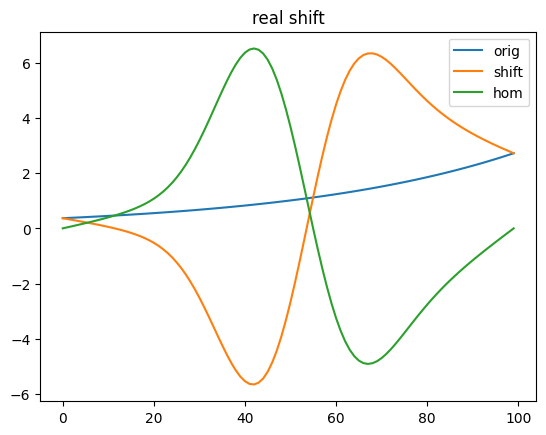

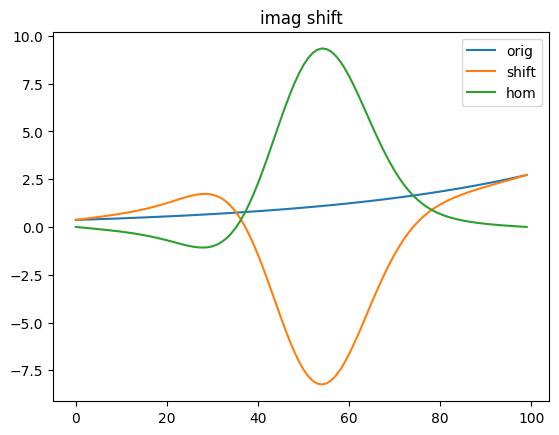

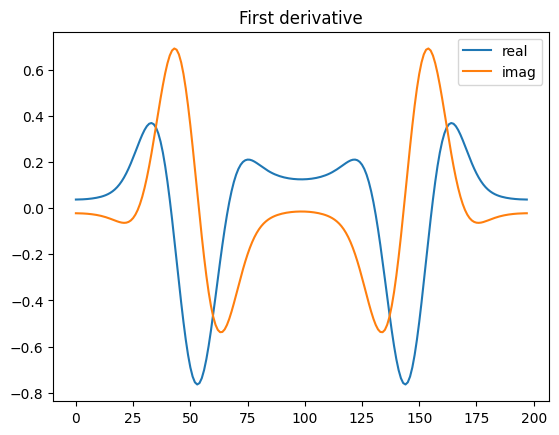

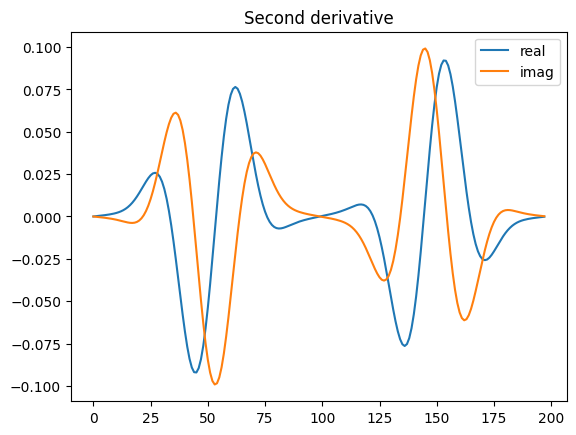

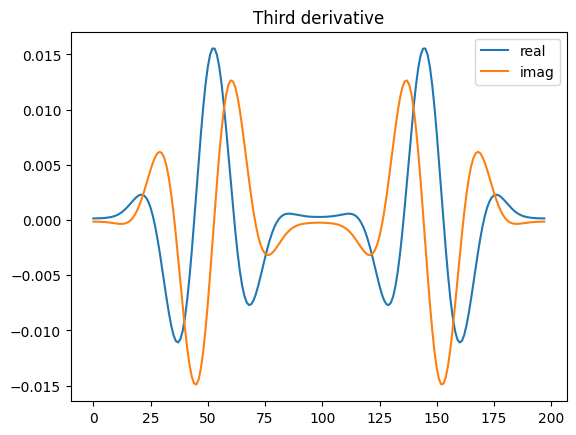

In [103]:
def planeWaveDiffVec(order, f, Dl, Dr):
    b = np.zeros(2*order, dtype = complex) 
    b[0] = f[ 0]
    b[1] = f[-1]
    for i in range(1, order): 
        b[i*2    ] = Dl[i]/(np.pi)**(2*i) 

    for i in range(1, order): 
        b[i*2 + 1] = Dr[i]/(np.pi)**(2*i) 

    return b 

def planeWaveDiffMat(order): 
    A = np.zeros((order*2, order*2), dtype=complex)
    for i in range(order): 
        derivative  = 2 * i 
        for j in range(1, 2*order+1):
            #Every derivative gives a factor of j -- j**derivative
            #Every second derivative gives a minus sign -- (-1)**i 
            #Cosine evaluated at pi gives negative i depending on wavelength -- (-1)**j
            A[2*i  , j-1] = j**derivative * (-1)**i
            A[2*i+1, j-1] = j**derivative * (-1)**i * (-1)**j 

    return A

def reconstruct(C, x, derivative_order = 0):
    f     = np.zeros(x.shape, dtype=complex) 
    L     = x[-1] - x[0]
    xeval = shiftx(x) 
    
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi / L) ** derivative_order * np.exp(1j * k * np.pi * xeval)

    return f




def getShiftFunction(f, order, x): 
    xeval = shiftx(x) 
    dx = xeval[1] - xeval[0]
    A = fDiffMat (order, dx) 
    b = fDiffVec (order, f)
    Dl = iterativeRefinement(A, b)

    A = bDiffMat (order, dx) 
    b = bDiffVec (order,  f)

    Dr = iterativeRefinement(A, b)

    print(int(order/2) + 1)


    A = planeWaveDiffMat(int(order/2) + 1) 
    b = planeWaveDiffVec(int(order/2) + 1, f, Dl, Dr)
    C = iterativeRefinement(A, b)


    shift = reconstruct(C, xeval)
    return shift, C, xeval

def antisymmetricExtension(f, debug=False):
    fext = np.concatenate([f, -np.flip(f)[1:-1]])
    if debug: 
        plt.title("First derivative")
        df = (np.roll(fext, -1) - fext)
        plt.plot(df.real, label="real")
        plt.plot(df.imag, label="imag")
        plt.legend()
        plt.show()
        plt.title("Second derivative")
        ddf = np.roll(fext, -1) - 2 * fext + np.roll(fext, 1)
        plt.plot(ddf.real, label="real")
        plt.plot(ddf.imag, label="imag")
        plt.legend()
        plt.show()
        plt.title("Third derivative")
        dddf = np.roll(df, -1) - 2 * df + np.roll(df, 1)
        plt.plot(dddf.real, label="real")
        plt.plot(dddf.imag, label="imag")
        plt.legend()
        plt.show()
    return fext 


def getk(p, dx): 
    N = len(p) 
    L = len(p) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k) 

x     = np.linspace(-1, 1, 100)
f     = np.exp(x) + 1j * np.exp(x)

order = 5
A = planeWaveDiffMat(order) 
b = planeWaveDiffVec(order, f, Dl, Dr)
C = iterativeRefinement(A, b)
xeval = shiftx(x) 
dx = xeval[1] - xeval[0]
shift = reconstruct(C, xeval)


plt.title("real shift")
plt.plot(f.real, label="orig") 
plt.plot(shift.real, label="shift")
plt.plot(f.real - shift.real, label="hom")
plt.legend()
plt.show()
plt.title("imag shift")
plt.plot(f.imag, label="orig") 
plt.plot(shift.imag, label="shift")
plt.plot(f.imag - shift.imag, label="hom")
plt.legend()
plt.show()


fext = antisymmetricExtension(f - shift, debug=True)

Finished in 0 iterations with residual error 2.3060732986917945e-16
Finished in 0 iterations with residual error 1.4130832128153977e-15
5
Finished in 0 iterations with residual error 6.437226536308039e-10


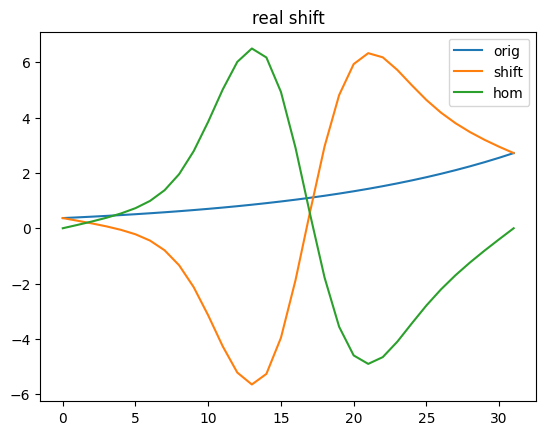

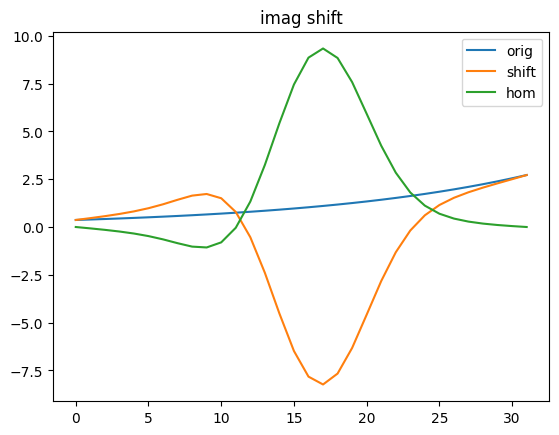

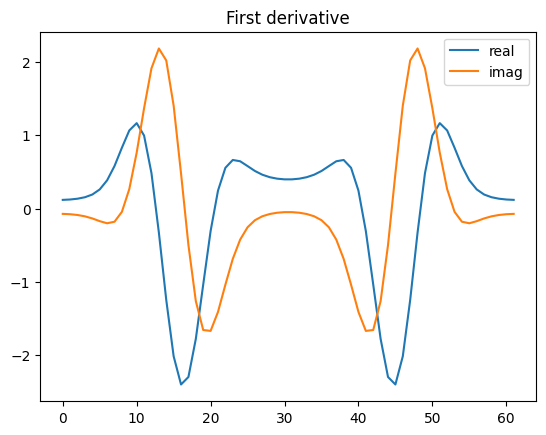

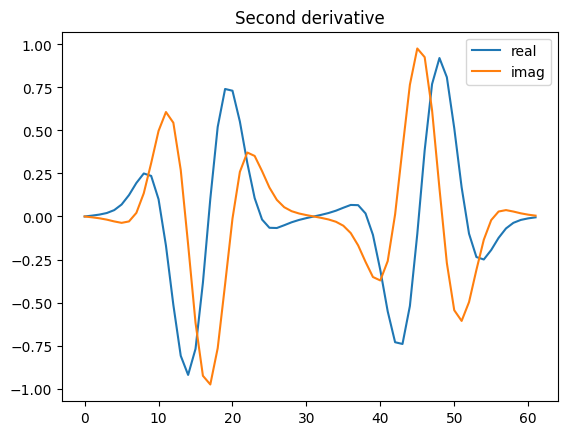

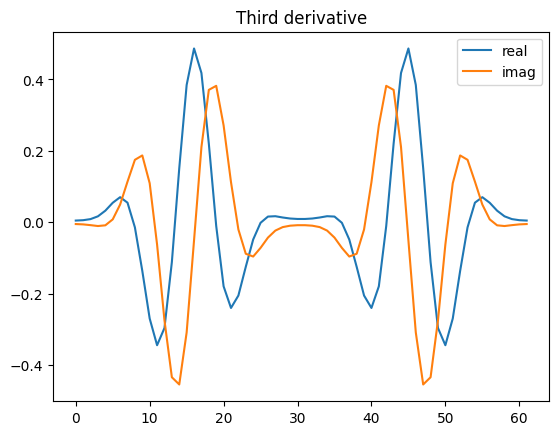

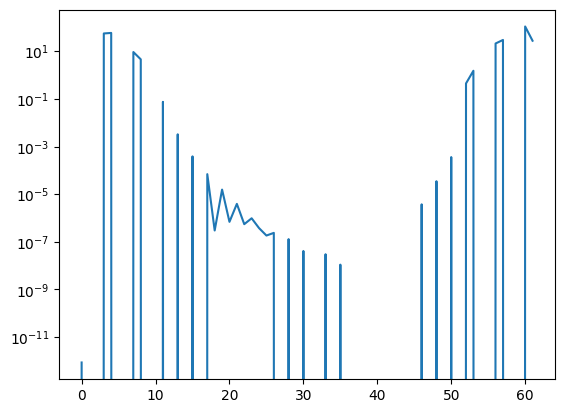

In [104]:
x = np.linspace(-1, 1, 32) 
dx = x[1] - x[0]
f = np.exp(x) + 1j * np.exp(x)
shift, C, xeval = getShiftFunction(f, 9, x) 
plt.title("real shift")
plt.plot(f.real, label="orig") 
plt.plot(shift.real, label="shift")
plt.plot(f.real - shift.real, label="hom")
plt.legend()
plt.show()
plt.title("imag shift")
plt.plot(f.imag, label="orig") 
plt.plot(shift.imag, label="shift")
plt.plot(f.imag - shift.imag, label="hom")
plt.legend()
plt.show()
fext = antisymmetricExtension(f - shift, debug=True)
fhat = scipy.fft.fft(fext)
plt.yscale("log")
plt.plot(fhat.imag)

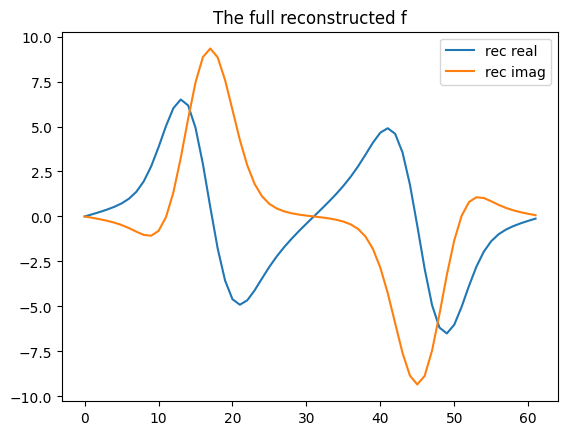

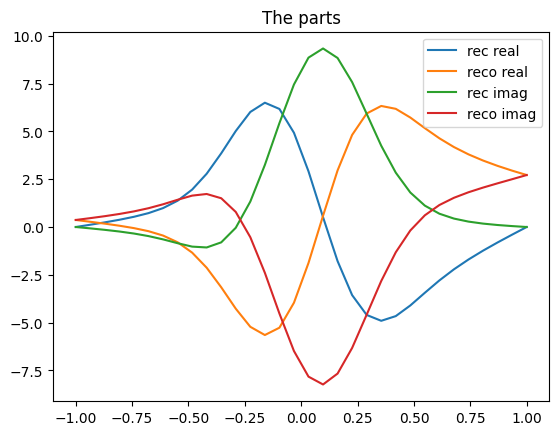

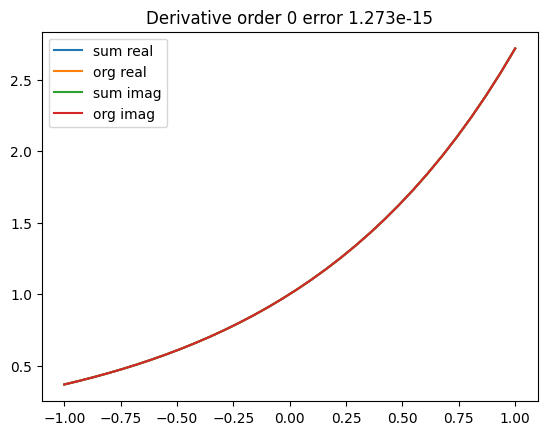

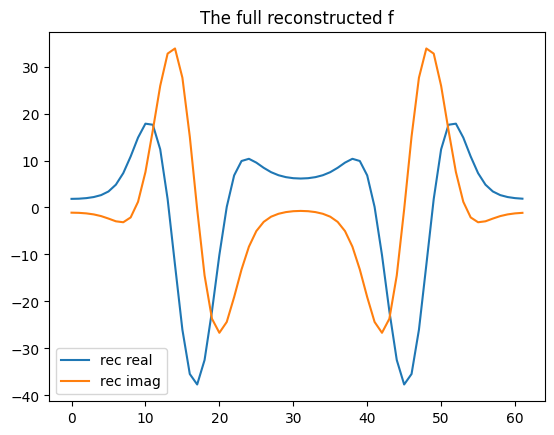

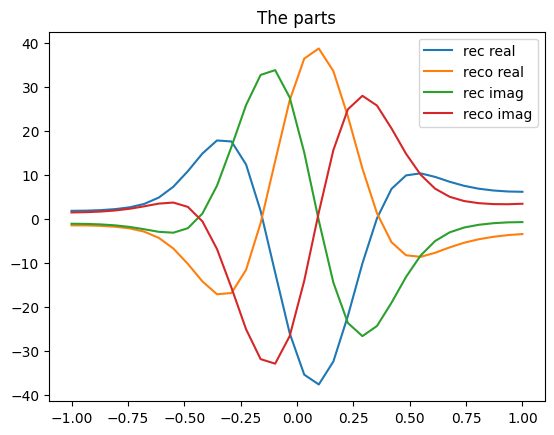

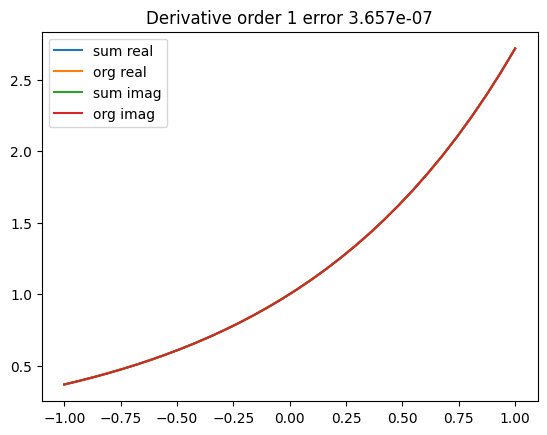

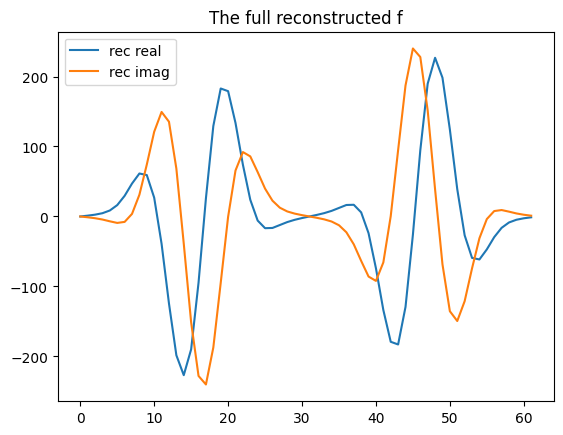

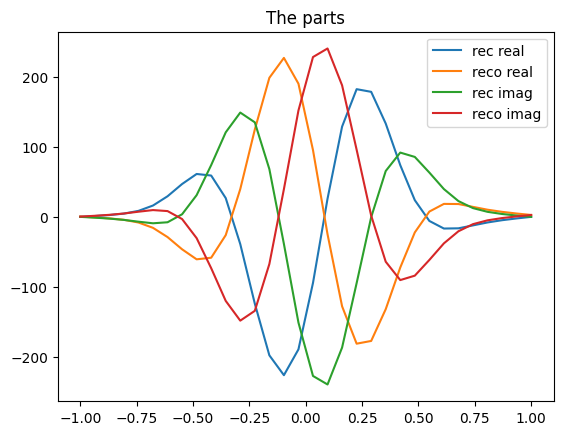

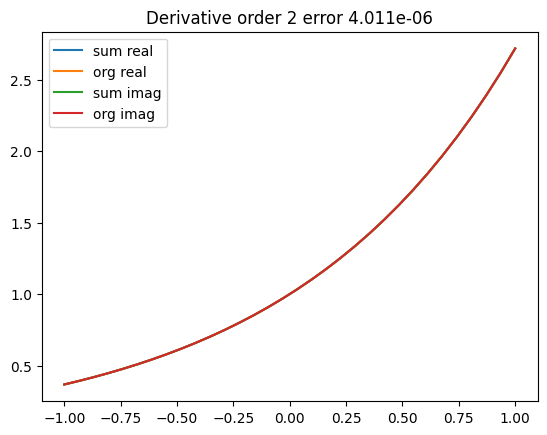

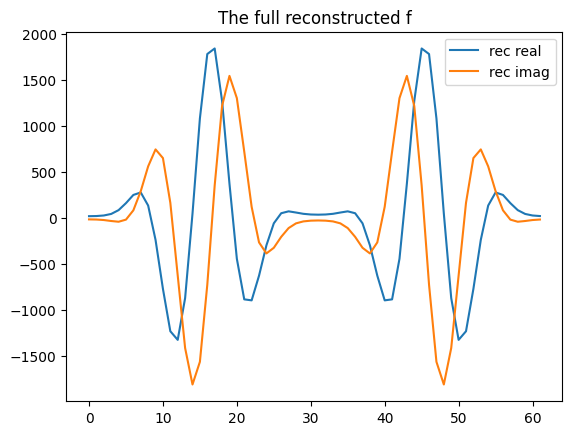

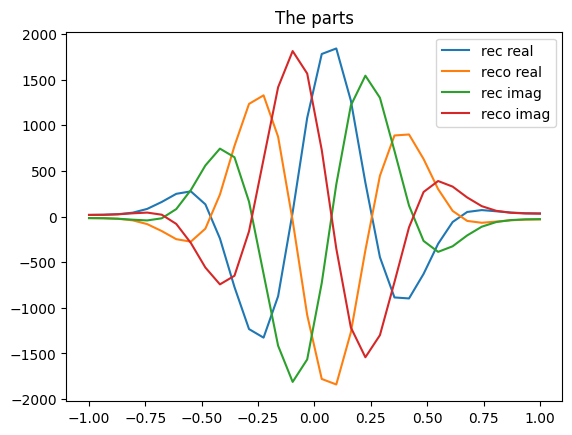

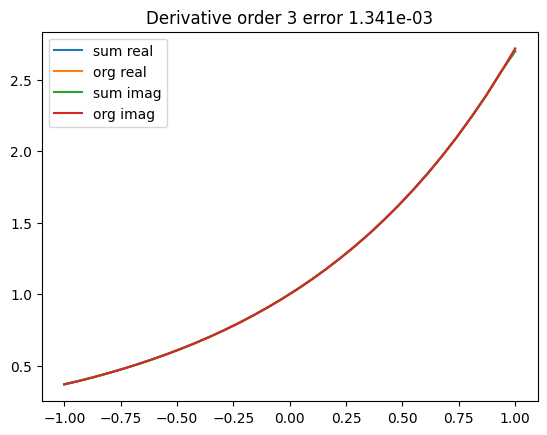

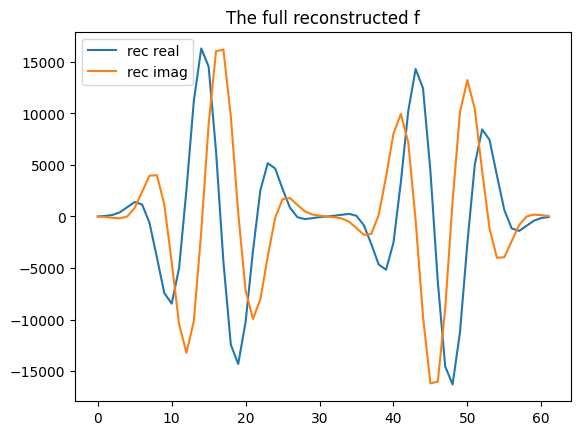

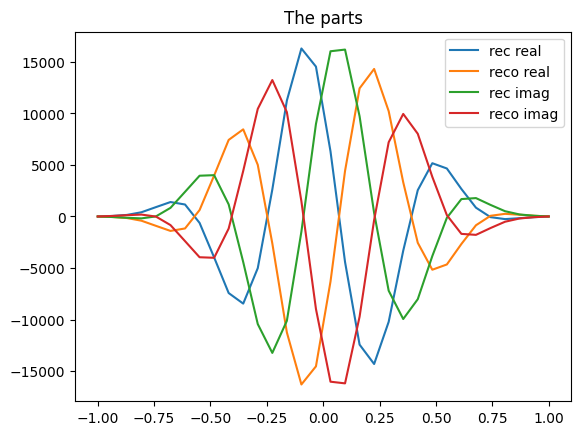

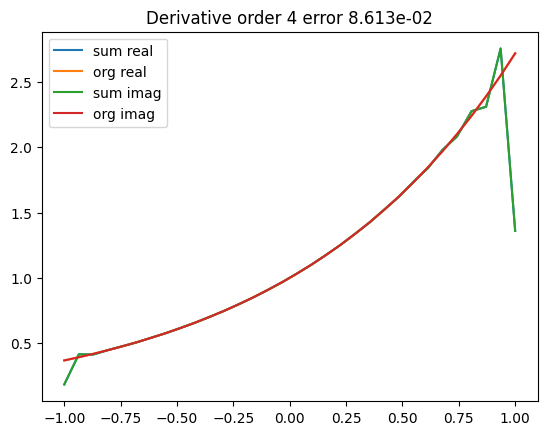

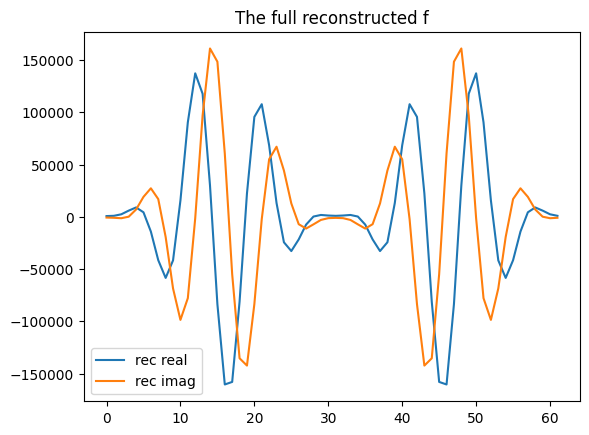

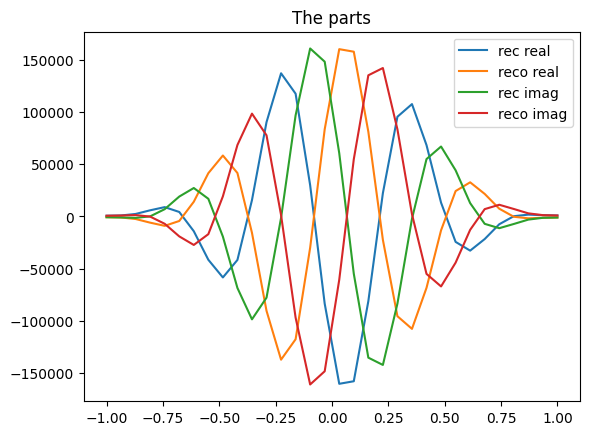

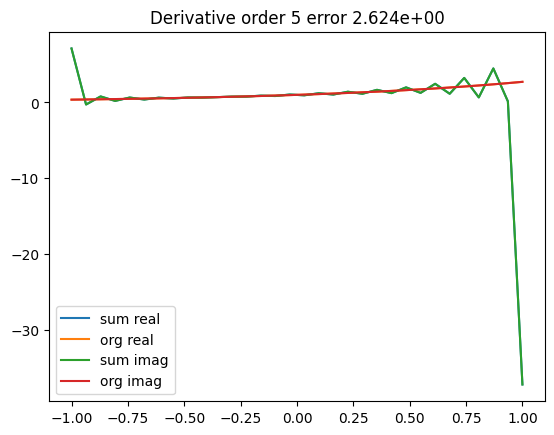

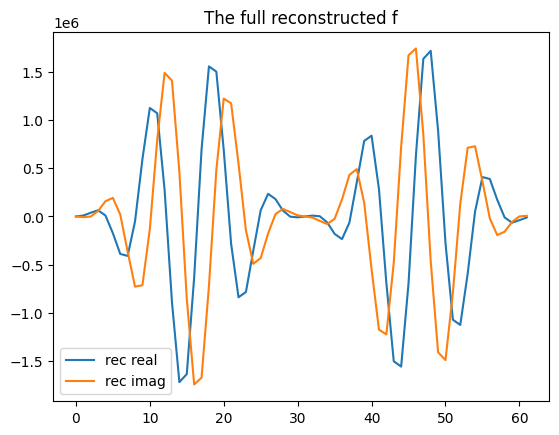

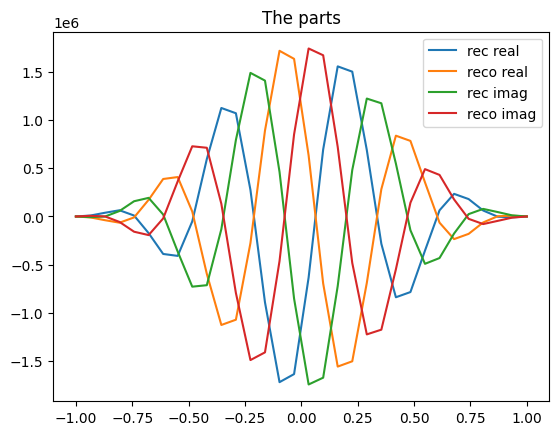

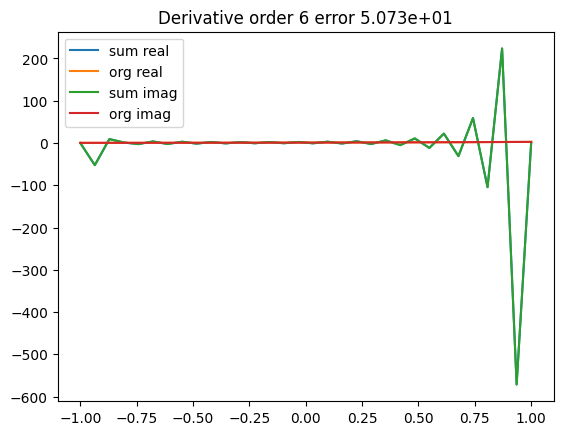

In [105]:

def getk(p, dx): 
    N = len(p) 
    L = (len(p)) * dx
    k = 2 * np.pi/ L * np.arange(-N/2, N/2)
    return np.fft.ifftshift(k) 

def reconstruct(C, x, derivative_order = 0):
    f     = np.zeros(x.shape, dtype=complex) 
    L     = x[-1] - x[0]
    xeval = shiftx(x) 
    
    for k in range(1, len(C) + 1):
        f += C[k-1] * (1j * k * np.pi/L) ** derivative_order * np.exp(1j * k * np.pi * xeval)

    return f

k = getk(fhat, dx) 

for i in range(7): 
    forg = np.exp(x) + 1j * np.exp(x) 
    frec = scipy.fft.ifft(fhat * (1j*k)**i)
    plt.title("The full reconstructed f")
    plt.plot(frec.real, label="rec real") 
    plt.plot(frec.imag, label="rec imag") 

    plt.legend()
    plt.show() 
    frec = frec[:32]
    reco = reconstruct(C, x, i)
    sumo = frec + reco 
    plt.title("The parts")
    plt.plot(x, frec.real, label="rec real") 
    plt.plot(x, reco.real, label="reco real") 
    plt.plot(x, frec.imag, label="rec imag") 
    plt.plot(x, reco.imag, label="reco imag") 

    plt.legend()
    plt.show() 
    plt.title(f"Derivative order {i} error {np.mean(np.abs(sumo-forg)):3.3e}")
    plt.plot(x, sumo.real, label="sum real") 
    plt.plot(x, forg.real, label="org real") 
    plt.plot(x, sumo.imag, label="sum imag") 
    plt.plot(x, forg.imag, label="org imag") 
    plt.legend()
    plt.show() 

Finished in 0 iterations with residual error 1.962615573354719e-17
Finished in 0 iterations with residual error 0.0
1
Finished in 0 iterations with residual error 0.0
Finished in 0 iterations with residual error 5.887846720064157e-17
Finished in 0 iterations with residual error 3.925231146709438e-16
2
Finished in 0 iterations with residual error 3.689717277906871e-15
Finished in 0 iterations with residual error 7.850462293418876e-17
Finished in 0 iterations with residual error 2.355138688025663e-16
3
Finished in 0 iterations with residual error 4.929697797152383e-13
Finished in 0 iterations with residual error 5.887846720064157e-16
Finished in 0 iterations with residual error 3.1401849173675503e-16
4
Finished in 0 iterations with residual error 1.3274572392732912e-11
Finished in 0 iterations with residual error 7.654200736083403e-16
Finished in 0 iterations with residual error 4.631772753117137e-15
5
After 1 iterations with residual error 1.5437531125965619e-09
After 2 iterations with 

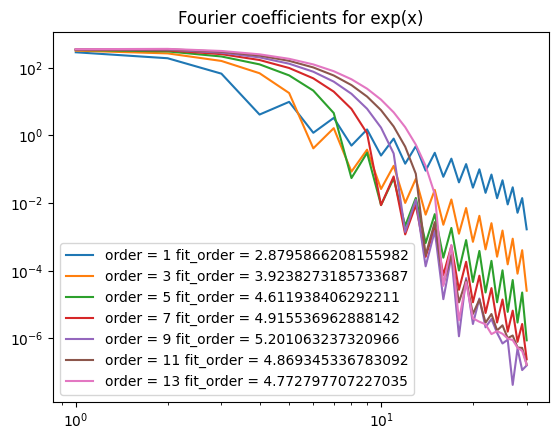

Finished in 0 iterations with residual error 7.850462293418876e-17
Finished in 0 iterations with residual error 0.0
1
Finished in 0 iterations with residual error 0.0
Finished in 0 iterations with residual error 7.850462293418876e-17
Finished in 0 iterations with residual error 6.431098710768743e-12
2
Finished in 0 iterations with residual error 2.3473510294305913e-11
Finished in 0 iterations with residual error 7.850462293418876e-17
Finished in 0 iterations with residual error 1.4148417163691235e-11
3
After 1 iterations with residual error 8.434134744379816e-10
Finished in 1 iterations with residual error 8.434134744379816e-10
Finished in 0 iterations with residual error 8.007471539287253e-15
Finished in 0 iterations with residual error 4.24452514910737e-11
4
After 1 iterations with residual error 2.2963243057188147e-07
After 2 iterations with residual error 5.820128506713729e-08
After 3 iterations with residual error 1.1589764096030154e-07
After 4 iterations with residual error 1.134

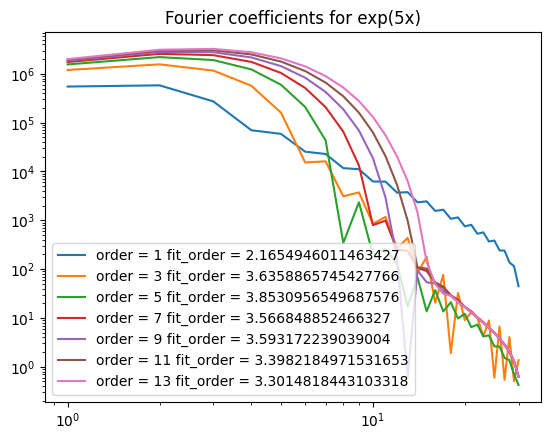

Finished in 0 iterations with residual error 0.0
Finished in 0 iterations with residual error 0.0
1
Finished in 0 iterations with residual error 0.0
Finished in 0 iterations with residual error 3.925231146709438e-17
Finished in 0 iterations with residual error 4.415885040048117e-17
2
Finished in 0 iterations with residual error 6.529530014946149e-16
Finished in 0 iterations with residual error 1.5700924586837752e-16
Finished in 0 iterations with residual error 3.4345772533707586e-17
3
Finished in 0 iterations with residual error 1.4649804333753395e-14
Finished in 0 iterations with residual error 5.887846720064157e-16
Finished in 0 iterations with residual error 3.925231146709438e-17
4
Finished in 0 iterations with residual error 2.8641250545014315e-12
Finished in 0 iterations with residual error 4.906538933386797e-16
Finished in 0 iterations with residual error 9.813077866773594e-17
5
Finished in 0 iterations with residual error 3.800925017989505e-10
Finished in 0 iterations with resid

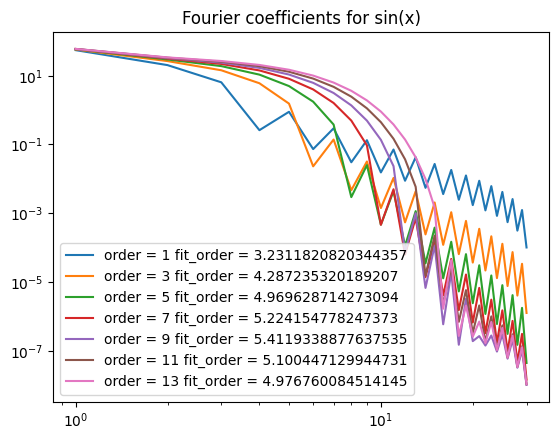

Finished in 0 iterations with residual error 1.5700924586837752e-16
Finished in 0 iterations with residual error 0.0
1
Finished in 0 iterations with residual error 0.0
Finished in 0 iterations with residual error 4.710277376051326e-16
Finished in 0 iterations with residual error 7.850462293418876e-16
2
Finished in 0 iterations with residual error 7.536443801682121e-15
Finished in 0 iterations with residual error 4.474763507248759e-15
Finished in 0 iterations with residual error 2.276634065091474e-15
3
Finished in 0 iterations with residual error 3.168446581623858e-13
Finished in 0 iterations with residual error 1.2227095021999899e-14
Finished in 0 iterations with residual error 2.0175688094086508e-14
4
Finished in 0 iterations with residual error 3.5545087658273185e-11
Finished in 0 iterations with residual error 5.868220564330609e-14
Finished in 0 iterations with residual error 1.4256439524848677e-13
5
After 1 iterations with residual error 2.010456604589305e-09
After 2 iterations wit

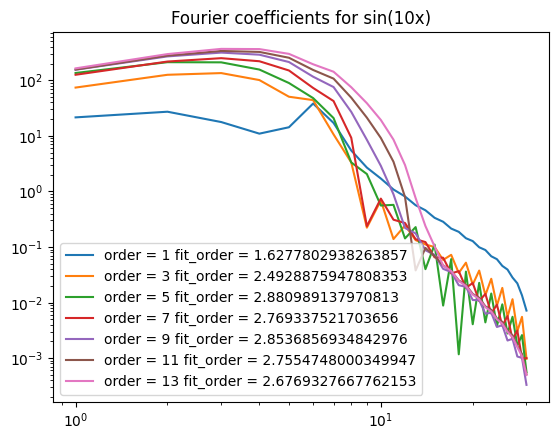

In [106]:
x = np.linspace(0, 2, 32)
fs = [np.exp(x) + 1j * np.exp(x), np.exp(5*x) + 1j * np.exp(5*x), np.sin(x) + 1j * np.sin(x) , np.sin(x*10) + 1j * np.sin(x*10)]
ns = ["exp(x)", "exp(5x)", "sin(x)", "sin(10x)"]

if 0:
    for f, n in zip(fs, ns): 
        plt.title(f"Fourier coefficients for {n}") 
        plt.yscale("log") 
        for order in [1, 3, 5, 7, 9, 11, 13]: 
            shift, C, xeval = getShiftFunction(f, order, x)
            hom = f - shift 
            ext = antisymmetricExtension(hom)
            fhat = scipy.fft.fft(ext) 
            plt.plot(np.abs(fhat), label=f"order = {order}") 
        plt.legend()
        plt.show() 


for f, n in zip(fs, ns): 
    plt.title(f"Fourier coefficients for {n}") 
    for order in [1, 3, 5, 7, 9, 11, 13]: 
        shift, C, xeval = getShiftFunction(f, order, x)
        hom = f - shift 
        ext = antisymmetricExtension(hom)
        fhat = scipy.fft.fft(ext) 
        y    = np.abs(fhat)[1:int(len(fhat)/2)]
        r    = np.arange(1, len(y)+1)
        #print(len(y), len(r))
        def fitfunc(x, beta): 
            return np.log(y[0]) + beta * np.log(x)
        coeff, cov = scipy.optimize.curve_fit(fitfunc, r, np.log(y)) 
        #print(coeff)
        plt.loglog(r, y, label=f"order = {order} fit_order = {np.abs(coeff[0])}") 
        #plt.loglog(r, np.exp(fitfunc(r, coeff[0])), label=f"fit with {y[0]} * x ** {coeff[0]}") 
    plt.legend()
    plt.show() 